## Baseline-решение

В данном ноутбуке представлено baseline-решение задачи классификации направления изменения будущей ключевой ставки ЦБ РФ по семантике текущего пресс-релиза. Решение основано на использовании Bag of Words для получения текстовых эмбеддингов и логистической регрессии.

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


RANDOM_STATE = 41825352
DATASET_URL = '../data/cbr-press-releases.csv'

Загрузим датасет пресс-релизов, полученных с сайта ЦБ РФ:

In [ ]:
df = pd.read_csv(DATASET_URL, parse_dates=['date'])

Для последнего релиза неизвестна целевая переменная (направление изменения ключевой ставки), поэтому исключим его из датасета и сохраним отдельно:

In [3]:
df.sort_values('date', inplace=True)
cur_pr = df.tail(1)
df = df[:-1]

В качестве целевой переменной используется столбец `target_categorial`.

In [4]:
y = df.target_categorial

### Подготовка модели

Создадим пайплайн, который будет включать:
1. Векторизацию столбца текстов (`release`) с помощью алгоритма Bag of Words, все остальные столбцы отбрасываются;
2. Классификатор - модель логистической регрессии.

In [5]:
model = Pipeline([
    ('vectorizer',
        ColumnTransformer([
            ('bag_of_words', CountVectorizer(), 'release')
        ], remainder="drop")
    ),
    ('log_regression', LogisticRegression(max_iter=1000))
])

### Оценка качества модели

Поскольку датасет небольшой, используем кросс-валидацию для оценки качества модели. Разбиение на фолды будем делать со стратификацией, чтобы в тестовую выборку попадали объекты всех классов.

In [17]:
# TODO: отобрать нужные метрики
scoring = [
    'accuracy',
    'f1_macro',
    'f1_micro',
    'f1_weighted',
    'precision_macro',
    'precision_micro',
    'precision_weighted',
    'recall_macro',
    'recall_micro',
    'recall_weighted',
    'roc_auc_ovr',
    'roc_auc_ovo',
]

# TODO: сколько брать фолдов?
folds = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
result = cross_validate(model, df, y, cv=folds, scoring=scoring, n_jobs=-1, return_train_score=True)

sc = pd.DataFrame(index=['mean', 'std'])
for score in scoring:
    scores = result['test_' + score]
    mean = scores.mean()
    s = pd.DataFrame({ score: [scores.mean(), scores.std()] }, index=['mean', 'std'])
    sc = pd.merge(sc, s, right_index=True, left_index=True)

sc

,accuracy,f1_macro,f1_micro,f1_weighted,precision_macro,precision_micro,precision_weighted,recall_macro,recall_micro,recall_weighted,roc_auc_ovr,roc_auc_ovo
mean,0.606316,0.601469,0.606316,0.599540,0.661946,0.606316,0.645545,0.598333,0.606316,0.606316,0.805142,0.818750
std,0.105809,0.110825,0.105809,0.110902,0.138313,0.105809,0.134030,0.103602,0.105809,0.105809,0.062859,0.057356


Средняя доля правильных ответов и F-мера среди всех тестовых данных приблизительно равны 0.6, стандартное отклонение $\approx 0.11$.

TODO: выводы

Здесь доп исследование, как кол-во фолдов влияет на среднуюю и стд. откл. у accuracy. Средняя и отклонение растет. Это не нужно, наверное

In [7]:
xs, ys, zs = [], [], []
for cnt in range(3, df.shape[0]):
    folds = KFold(cnt, shuffle=True, random_state=RANDOM_STATE)
    result = cross_validate(model, df, y, cv=folds, scoring=scoring, n_jobs=-1, return_train_score=True)

    xs.append(cnt)
    ys.append(result['test_accuracy'].mean())
    zs.append(result['test_accuracy'].std())

(0.0, 20.0)

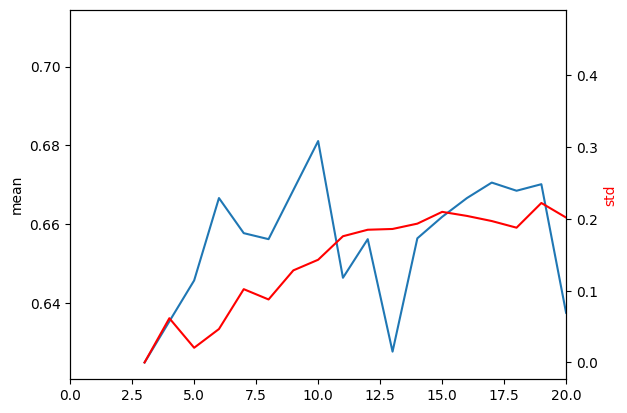

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()

ax2 = axes.twinx()

axes.plot(xs, ys)
ax2.plot(xs, zs, color='red')

axes.set_ylabel('mean')
ax2.set_ylabel('std', color='red')

axes.set_xlim((0, 20))

### Предсказание следующей ключевой ставки

Теперь применим базовую модель к последнему пресс-релизу и определим прогноз по ключевой ставке на следующем заседании совета директоров ЦБ РФ 20 декабря 2024 г.:

In [ ]:
model.fit(df, y)
model.predict_proba(cur_pr)

array([[0.00331463, 0.01862424, 0.97806113]])

Модель предсказывает решение о повышении ключевой ставки на следующем заседании с вероятностью 0.978.